In [1]:
import pickle
from math import floor
from IPython.display import display, clear_output
import scipy.stats
from pylab import * 
import numpy as np
import seaborn as sns
import pandas
from itertools import product as iterproduct, groupby
%matplotlib inline
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/analysis_lib.ipynb"
sns.set_style("ticks", {"axes.grid" : True, "grid.color" : ".95"})
matplotlib.rcParams.update({'font.size': 16})

In [2]:
# args = {
#     "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/david_alignment_true_events.pickle",
#     "ref": "/home/ibis/gregor.sturm/nanopore/david_eccles_bc_ideas/mouse_ref.fa",
# }

args = {
    "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_alignment_true_events.pickle",
    "ref": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_ref.fasta",
}

In [3]:
NMER = 3
CONTEXT = 200

In [4]:
!pwd

/home/ibis/gregor.sturm/nanopore/own/notebooks


In [5]:
true_events = pickle.load(open(args["true_events"], 'rb'))

In [6]:
ref_file = args["ref"]
test = !cat {ref_file} | grep ">"
print(test)
ref = !cat {ref_file} | grep -v ">"
ref = ref[0]
print(ref[:100])

['>burn-in lambda_ref']
GGGCGGCGACCTCGCGGGTTTTCGCTATTTATGAAAATTTTCCGGTTTAAGGCGTTTCCGTTCTTCTTCGTCATAACTTAATGTTTTTATTTAAAATACC


In [7]:
def get_context(event, start, end):
    """get the nt-context around the kmer. 
    E.g. start=-20: get context 20nt before the reference point
    (mid of kmer)"""
    ref_pos = event["ref_position"]
    start = ref_pos + start
    end = ref_pos + end
    context = ref[start:end]
    if len(context) != end-start:
        print(start, end, len(ref), len(context), end-start)
        raise IndexError
    else: return context

def get_context_before(event, n):
    """get n nucleotides before the start of the kmer"""
    length = len(event["kmer"])
    offset = int(-floor(length/2))
    return get_context(event, -n+offset, offset)
    
def get_context_after(event, n):
    length = len(event["kmer"])
    offset = int(floor(length/2) + 1)
    return get_context(event, offset, offset+n)

In [8]:
test_event = true_events[0]
assert test_event['kmer'] == get_context(test_event, -2, 2+1), "invalid reference"
assert (get_context_before(test_event, 20) 
        + test_event['kmer'] 
        + get_context_after(test_event, 20)) == (
    get_context(test_event, -22, 22+1))

## Analysis 

In [9]:
all_5mers = mk_kmer_dict(NMER)
ev_map = mk_event_map(true_events, all_5mers)

In [10]:
def prepare_events(kmer):
    template_events = [ev for ev in ev_map[kmer] if not np.isnan(ev["template.mean"])]
    template_events = [ev for ev in template_events if 
                   ev["ref_position"] > CONTEXT+NMER+1 and ev["ref_position"] < len(ref)-CONTEXT-NMER-1]
    print("kmer {0}".format(kmer))
    print(">>genomic_positions {0}".format(len(set([ev["ref_position"] for ev in template_events]))))
    print(">>total_events {0}".format(len(template_events)))
    return template_events

In [11]:
def stratify_by_position(template_events, skip=10):
    """group events by genomic positions. 
    
    Args: 
        template_events: list of events
        skip: skip genomic positions with less than {skip} events. 
    
    Returns: 
        dict pos => (mean, stdv, context_before, context_after) of the
        given position. 
    """
    sort_position = lambda x: x["ref_position"]
    template_events = sorted(template_events, key=sort_position)
    groups = {key: [x for x in group] for key, group in groupby(template_events, sort_position)}
    genomic_pos = OrderedDict()
    for key, group in groups.items():
        means = [x["template.mean"] for x in group]
        if(len(means) < skip): 
#             print("skipped {0}".format(key))
            continue
        else:
            assert get_context_before(group[0], CONTEXT) == get_context_before(group[-1], CONTEXT)
            genomic_pos[key] = {
                "event_means" : means,
                "mean" : np.mean(means),
                "stdv" : np.std(means),
                "context_before": get_context_before(group[0], CONTEXT),
                "context_after": get_context_after(group[0], CONTEXT)
        }
    
    return genomic_pos                                                       

In [12]:
def make_heatmap(genomic_pos, sort_heatmap, keys): 
    occurences = sorted(genomic_pos.values(), key=sort_heatmap)
    overall_mean = mean([x["mean"] for x in occurences])
    heatmap = {nt: {nt: np.nan for nt in keys} for nt in keys}
    for (nt_b, nt_a), group in groupby(occurences, sort_heatmap):
        heatmap[nt_b][nt_a] = mean([x["mean"] for x in group]) - overall_mean
    return heatmap

In [13]:
sort_heatmap1 = lambda x: (x["context_before"][0], x["context_after"][0])
sort_heatmap2 = lambda x: (x["context_before"][0:2], x["context_after"][:2])
keys1 = [x for x in "ACGT"]
keys2 = ["".join(x) for x in iterproduct("ACGT", repeat=2)]
heatmaps = []
heatmaps2 = []
heatmaps3 = []
for kmer in ev_map.keys(): 
    template_events = prepare_events(kmer)
    genomic_pos = stratify_by_position(template_events)
    heatmap = make_heatmap(genomic_pos, sort_heatmap1, keys1)
    heatmaps.append(pandas.DataFrame(heatmap).as_matrix())
    heatmap2 = make_heatmap(genomic_pos, sort_heatmap2, keys2)
    heatmaps2.append(pandas.DataFrame(heatmap2).as_matrix())

kmer AAA
>>genomic_positions 1230
>>total_events 69242
kmer AAC
>>genomic_positions 849
>>total_events 64725
kmer AAG
>>genomic_positions 739
>>total_events 44947
kmer AAT
>>genomic_positions 828
>>total_events 67469
kmer ACA
>>genomic_positions 665
>>total_events 50552
kmer ACC
>>genomic_positions 676
>>total_events 36509
kmer ACG
>>genomic_positions 712
>>total_events 47660
kmer ACT
>>genomic_positions 503
>>total_events 27030
kmer AGA
>>genomic_positions 683
>>total_events 46483
kmer AGC
>>genomic_positions 793
>>total_events 53634
kmer AGG
>>genomic_positions 651
>>total_events 43940
kmer AGT
>>genomic_positions 591
>>total_events 44012
kmer ATA
>>genomic_positions 665
>>total_events 51265
kmer ATC
>>genomic_positions 770
>>total_events 66390
kmer ATG
>>genomic_positions 990
>>total_events 77085
kmer ATT
>>genomic_positions 880
>>total_events 76690
kmer CAA
>>genomic_positions 693
>>total_events 53891
kmer CAC
>>genomic_positions 580
>>total_events 35493
kmer CAG
>>genomic_position

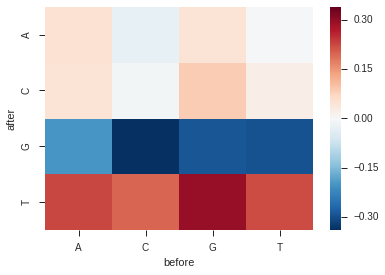

In [14]:
fig, ax = subplots()
heatmap_mean = np.nanmean(heatmaps, axis=0)
sns.heatmap(heatmap_mean, xticklabels = keys1, yticklabels=keys1, ax=ax)
ax.set_xlabel("before")
ax.set_ylabel("after")

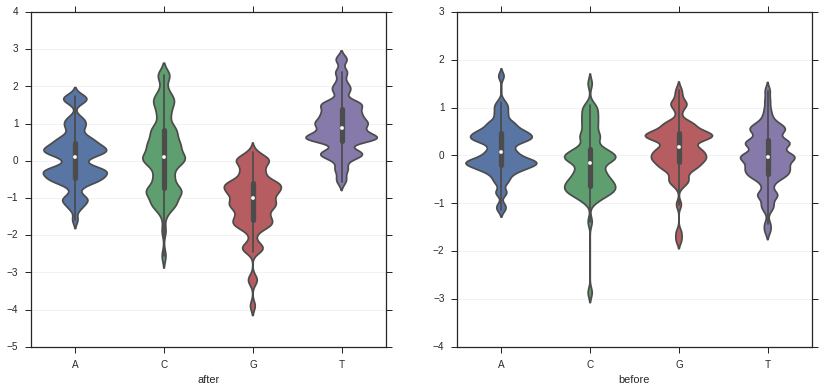

In [15]:
fig, (ax1, ax2) = subplots(1,2, figsize=(14,6))
violin_before = [np.sum(hm, axis=1) for hm in heatmaps] #axis0 = y,axis1 = x
violin_after = [np.sum(hm, axis=0) for hm in heatmaps] #axis0 = y,axis1 = x
df_before = pandas.DataFrame(np.vstack(violin_before), columns=keys1)
df_after = pandas.DataFrame(np.vstack(violin_after), columns=keys1)
sns.violinplot(data=df_before, ax=ax1, bw=.15)
ax1.set_xlabel("after")
sns.violinplot(data=df_after, ax=ax2, bw=.15)
ax2.set_xlabel("before")

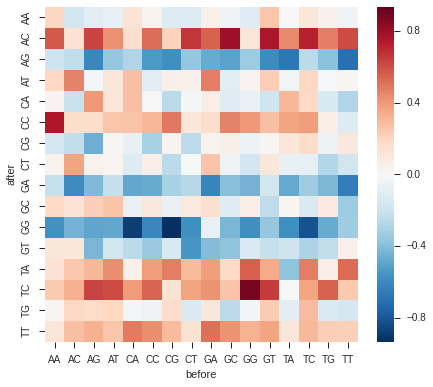

In [16]:
fig, ax = subplots(figsize=(7,6))
heatmap_mean = np.nanmean(heatmaps2, axis=0)
sns.heatmap(heatmap_mean, xticklabels = keys2, yticklabels=keys2, ax=ax)
ax.set_xlabel("before")
ax.set_ylabel("after")

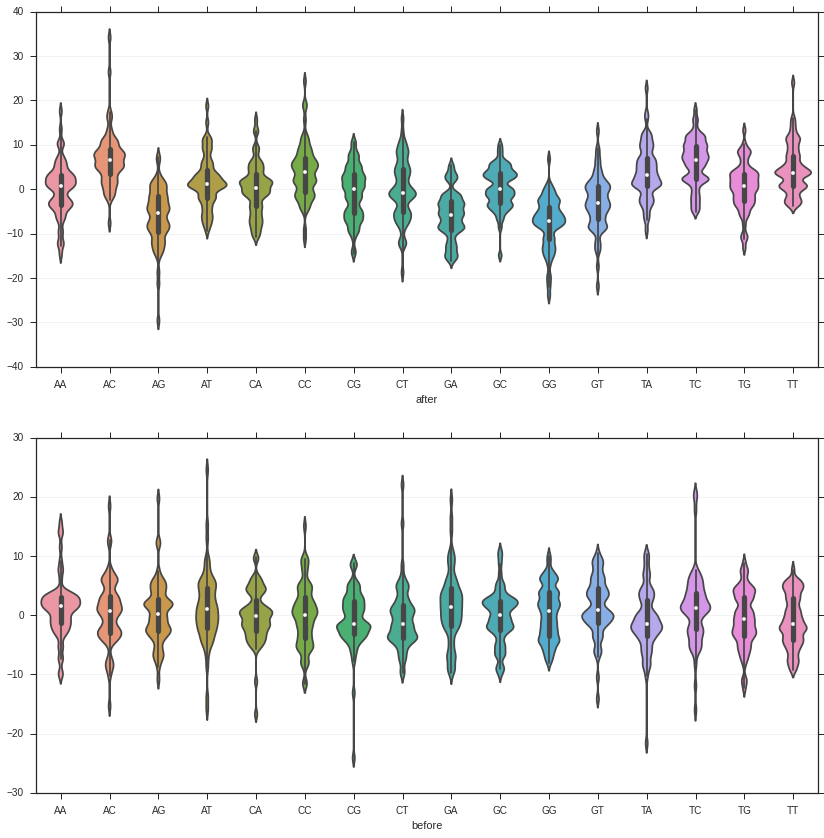

In [17]:
fig, (ax1, ax2) = subplots(2,1, figsize=(14,14))
violin_before = [np.nansum(hm, axis=1) for hm in heatmaps2] #axis0 = y,axis1 = x
violin_after = [np.nansum(hm, axis=0) for hm in heatmaps2] #axis0 = y,axis1 = x
df_before = pandas.DataFrame(np.vstack(violin_before), columns=keys2)
df_after = pandas.DataFrame(np.vstack(violin_after), columns=keys2)
sns.violinplot(data=df_before, ax=ax1, bw=.15)
ax1.set_xlabel("after")
sns.violinplot(data=df_after, ax=ax2, bw=.15)
ax2.set_xlabel("before")